In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np


# plot stuff
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set()
# my own stuff

plt.style.use('default')

from utils import *
from gtv import *
from make_figures import *

In [7]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'monthly')
yavg, Y, regions = load_response(X.shape[0])
S = X.T@X/X.shape[0]
D = edge_incidence(S, .85)
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dneigh = neighbors(fts)

In [8]:
tele_df = televaluation(Xnzi, Xenso, Xtele, yavg, 'Areal Average', .95, 50)
for i, y in enumerate(Y.T):
    t = televaluation(Xnzi, Xenso, Xtele, y, regions[i], .95, 50)
    tele_df = tele_df.append(t, ignore_index=True)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [9]:
# regular lasso 
lasso_errors = []
alpha=.95
X_train, X_test, y_train, y_test = temporal_split(X, yavg, 50)
if alpha<1:
    n = X_train.shape[0]
    weights = np.array([alpha**(n-t) for t in np.arange(1, n+1)])
    X_train = X_train * np.sqrt(weights.reshape(-1,1))
    y_train = y_train * np.sqrt(weights)

las = linear_model.LassoCV(cv=5)
las.fit(X_train, y_train)

mse, r2 = compute_errors(y_test, X_test@las.coef_)
lasso_errors.append(['Areal Average', 'Lasso', mse, r2, las.alpha_])

for i, y in enumerate(Y.T):
    print(regions[i])
    X_train, X_test, y_train, y_test = temporal_split(X, y, 50)
    if alpha<1:
        n = X_train.shape[0]
        weights = np.array([alpha**(n-t) for t in np.arange(1, n+1)])
        X_train = X_train * np.sqrt(weights.reshape(-1,1))
        y_train = y_train * np.sqrt(weights)
    las = linear_model.LassoCV(cv=5)
    las.fit(X_train, y_train)

    mse, r2 = compute_errors(y_test, X_test@las.coef_)
    lasso_errors.append([regions[i], 'Lasso', mse, r2, las.alpha_])
    
df_lasso = pd.DataFrame(lasso_errors, columns=['Region', 'Method', 'MSE', 'R2', 'coef'])

Arizona(1)
Utah(1)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Arizona(2)
Utah(2)
Arizona(3)
Nevada(3)
Arizona(4)
California(4)
Nevada(4)
Utah(4)
Arizona(5)
California(5)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Arizona(6)
California(6)
Utah(6)
Arizona(7)
California(7)
Utah(7)


In [10]:
D = edge_incidence(S, .8)
Dlens = edge_incidence(Slens, .8)

In [11]:
d7 = full_weighted_cv(X, yavg, 
                     {'gtv_lens':Dlens,
                     'gtv_obs':D}, 
                     lambda_gtv=np.linspace(0, 5, 5),
                     lambda_lasso=np.linspace(.01, .5, 5),
                     auto_cv=True, alpha=.95,
                     t=50,k=5)

In [12]:
d7.sort_values('test_mse').drop_duplicates('method')

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2
6,gtv_lens,3.75,0.068702,0.058299,0.853522,0.860445,0.238836
1,gtv_obs,0.00,0.369073,0.354156,0.110181,1.103304,0.023999


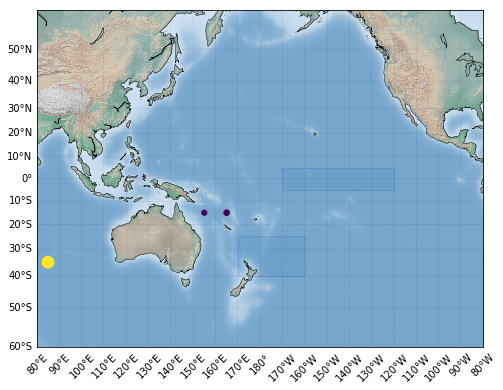

In [13]:
fts['coef'] = las.coef_
plot_coefs(fts)

In [219]:
d.sort_values(['method', 'test_mse']).drop_duplicates('method')

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2
3123,gtv_lens,5.000000,0.047692,0.040105,0.899235,0.763129,0.324923
123,gtv_obs,0.128205,0.047692,0.042140,0.894124,0.785074,0.305510


In [229]:
d2 = d[['method', 'lambda_tv', 'lambda_1', 'test_mse', 'test_r2']]
d2.columns = ['method', 'lambda_tv', 'lambda_1', 'mse', 'r2']
d2[['lambda_tv', 'lambda_1']] = d2[['lambda_tv', 'lambda_1']] .round(2)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


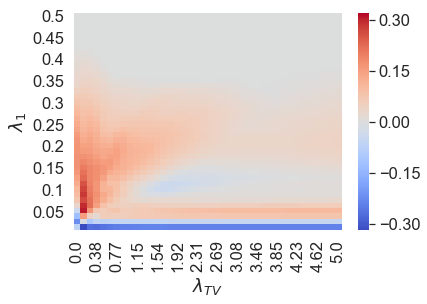

In [232]:
sns.set(font_scale=1.5)
draw_lambda_contour(d2, 'gtv_obs', 'r2', vmin=-.32, vmax=.32)

In [6]:
df_regions = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens,
                 'gtv_obs':D,
                 'fused':Dneigh}, 
                 lambda_gtv=np.linspace(.5, 20, 10),
                 lambda_lasso=np.linspace(.1, .5, 15),
                 auto_cv=False, alpha=.95,
                 t=50,k=5)
df_regions['Region'] = 'Areal Average'

for i, y in enumerate(Y.T):
    print(regions[i])
    d = full_weighted_cv(X, y, 
                 {'gtv_lens':Dlens,
                 'gtv_obs':D,
                 'fused':Dneigh}, 
                 lambda_gtv=np.linspace(.5, 20, 10),
                 lambda_lasso=np.linspace(.1, .5, 15),
                 auto_cv=False, alpha=.95,
                 t=50,k=5)

    d['Region'] = regions[i]   
    df_regions = df_regions.append(d, ignore_index=True)


Arizona(1)
Utah(1)
Arizona(2)
Utah(2)
Arizona(3)
Nevada(3)
Arizona(4)
California(4)
Nevada(4)
Utah(4)
Arizona(5)
California(5)
Arizona(6)
California(6)
Utah(6)
Arizona(7)
California(7)
Utah(7)


In [113]:
df_regions = full_weighted_cv(X, yavg, 
             {'gtv_lens':Dlens,
             'gtv_obs':D,
             'fused':Dneigh}, 
             lambda_gtv=np.linspace(.5, 20, 10),
             lambda_lasso=np.linspace(.1, .5, 15),
             auto_cv=True, alpha=.95,
             t=50,k=5)
df_regions['Region'] = 'Areal Average'

for i, y in enumerate(Y.T):
    print(regions[i])
    if 'Arizona' in regions[i]:
        d = full_weighted_cv(X, y, 
                     {'gtv_lens':Dlens,
                     'gtv_obs':D,
                     'fused':Dneigh}, 
                     lambda_gtv=np.linspace(.5, 20, 10),
                     lambda_lasso=np.linspace(.1, .5, 15),
                     auto_cv=False, alpha=.95,
                     t=50,k=5)
        
    else:
        d = full_weighted_cv(X, y, 
                     {'gtv_lens':Dlens,
                     'gtv_obs':D,
                     'fused':Dneigh}, 
                     lambda_gtv=np.linspace(.5, 20, 10),
                     lambda_lasso=np.linspace(.1, .5, 15),
                     auto_cv=True, alpha=.95,
                     t=50,k=5)
        
    d['Region'] = regions[i]   
    df_regions = df_regions.append(d, ignore_index=True)


Arizona(1)
Utah(1)
Arizona(2)
Utah(2)
Arizona(3)
Nevada(3)
Arizona(4)
California(4)
Nevada(4)
Utah(4)
Arizona(5)
California(5)
Arizona(6)
California(6)
Utah(6)
Arizona(7)
California(7)
Utah(7)


In [7]:
method_map = {
    'gtv_lens': 'GTV (CESM-LENS)',
    'gtv_obs': 'GTV (Obs)',
    'fused': 'Fused Lasso'
}

method_order = {
    'NZI': -3,
    'Nino 3.4':-2,
    'Nino 3.4 & NZI':-1,
    'Lasso':0,
    'Fused Lasso':1, 
    'GTV (Obs)':2,
    'GTV (CESM-LENS)':3
}

ordered_regions = list(df_regions.sort_values('Region').Region.unique()[1:])
ordered_regions.append('Areal Average')
region_order = {}
i = 0
for r in ordered_regions:
    region_order[r] = i
    i+=1

In [119]:
df_regions.sort_values(['Region', 'Method', 'test_mse']).drop_duplicates(['Region', 'Method'])

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2,Region,Method
2,fused,0.500000,0.194740,0.180609,0.546219,0.919903,0.186239,Areal Average,Fused Lasso
24,gtv_lens,17.833333,0.193733,0.212245,0.466733,0.800159,0.292165,Areal Average,GTV (CESM-LENS)
4,gtv_obs,2.666667,0.376831,0.398011,-0.000006,1.132166,-0.001533,Areal Average,GTV (Obs)
62,fused,0.500000,0.157143,0.114894,0.651313,1.100642,0.139106,Arizona(1),Fused Lasso
120,gtv_lens,4.833333,0.100000,0.075872,0.769740,1.000121,0.217731,Arizona(1),GTV (CESM-LENS)
450,gtv_obs,20.000000,0.100000,0.088663,0.730920,1.029272,0.194930,Arizona(1),GTV (Obs)
540,fused,0.500000,0.100000,0.074661,0.806363,0.859931,0.236683,Arizona(2),Fused Lasso
646,gtv_lens,7.000000,0.128571,0.121733,0.684281,0.817413,0.274424,Arizona(2),GTV (CESM-LENS)
930,gtv_obs,20.000000,0.100000,0.092542,0.759988,1.026228,0.089070,Arizona(2),GTV (Obs)
1020,fused,0.500000,0.100000,0.075624,0.792688,1.047917,0.166776,Arizona(3),Fused Lasso


In [8]:
df_regions['Method'] = df_regions.method.apply(lambda x: method_map[x])

In [9]:
d3 = df_regions.sort_values(['Region', 'Method', 'test_mse']).drop_duplicates(['Region', 'Method'])
d3 = d3[['Method', 'Region', 'test_mse', 'test_r2']]
d3.columns = ['Method', 'Region', 'MSE', 'R2']
d3 = d3.append(tele_df[['Method', 'Region', 'MSE', 'R2']])
d3 = d3.append(df_lasso[['Method', 'Region', 'MSE', 'R2']])
d3['method_order'] = d3.Method.apply(lambda x: method_order[x])
d3['region_order'] = d3.Region.apply(lambda x: region_order[x])
d3['Region'] = d3.Region.apply(lambda x: shorten_region(x))
d3['R2'] = d3.R2.apply(lambda x: max(.01, x))
d3 = d3.sort_values(['region_order', 'method_order'])

Text(0.5,0,'Region')

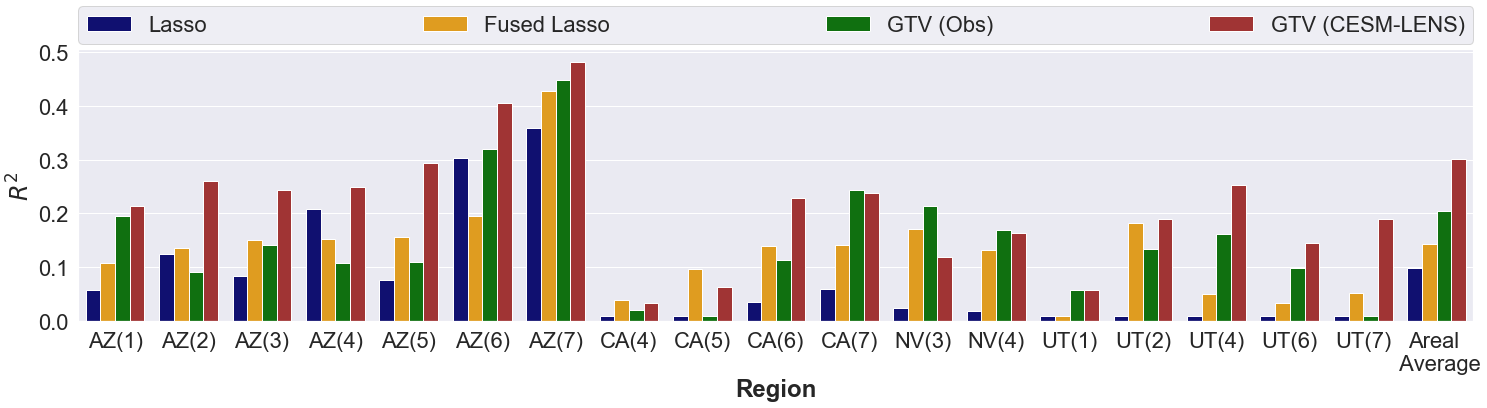

In [17]:
plt.figure(figsize=(25,5))
sns.set(font_scale=2)
sns.barplot(x='Region', y='R2', hue='Method', data=d3[
    d3.Method.isin(['Lasso', 'Fused Lasso', 'GTV (Obs)', 'GTV (CESM-LENS)'])],
           palette=['navy', 'orange', 'green', 'firebrick'])
plt.ylabel('$R^2$', fontweight='bold')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
plt.xlabel('Region', fontweight='bold')

In [12]:
len(yavg)

79

Text(0.5,0,'Region')

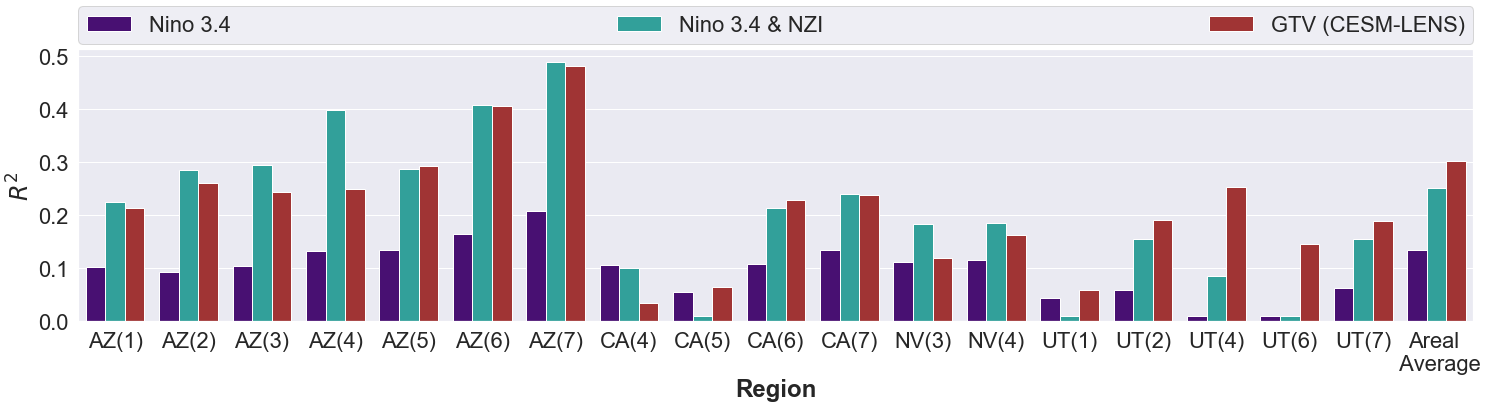

In [15]:
plt.figure(figsize=(25,5))
sns.set(font_scale=2)

sns.barplot(x='Region', y='R2', hue='Method', data=d3[
    d3.Method.isin(['Nino 3.4', 'Nino 3.4 & NZI', 'GTV (CESM-LENS)'])],
           palette = ['indigo', 'lightseagreen', 'firebrick'])
plt.ylabel('$R^2$', fontweight='bold')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
plt.xlabel('Region', fontweight='bold')

In [124]:
d3['Region'] = d3.Region.apply(lambda x: swap_region(x))

In [132]:
d3.pivot_table(index='Region', columns='Method', values='MSE')[['Nino 3.4', 
                                                                'Nino 3.4 & NZI', 
                                                                'Lasso',
                                                               'Fused Lasso',
                                                               'GTV (Obs)',
                                                               'GTV (CESM-LENS)']]

Method,Nino 3.4,Nino 3.4 & NZI,Lasso,Fused Lasso,GTV (Obs),GTV (CESM-LENS)
Region,,,,,,
Areal \n Average,0.978462,0.845787,1.019505,0.919903,1.132166,0.800159
Arizona(1),1.147629,0.991479,1.205755,1.100642,1.029272,1.000121
Arizona(2),1.022395,0.805011,0.985965,0.859931,1.026228,0.817413
Arizona(3),1.127283,0.887844,1.151509,1.047917,1.034179,0.934814
Arizona(4),0.975058,0.675824,0.888861,0.898597,0.936733,0.819754
Arizona(5),1.180101,0.970657,1.257796,1.144004,1.159050,0.962105
Arizona(6),0.956595,0.677809,0.798092,0.842827,0.746826,0.677038
Arizona(7),0.923230,0.595838,0.747085,0.666800,0.637314,0.603151
California(4),0.848686,0.854891,0.943258,0.964773,0.964773,0.964773


In [56]:
beta = weighted_gtv2(X[:50], yavg[:50], Dlens, 10, .23, alpha=.975)
compute_errors(yavg[50:75], X[50:75]@beta)

(0.7983391472100508, 0.30883082082878466)

In [28]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'seasonal')
yavg, Y, regions = load_response(X.shape[0])
S_obs_season = X.T@X/X.shape[0]
S_obs_season_lens = Xlens.T@Xlens/Xlens.shape[0]


for alpha in [.9, .95, .975]:
    t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    #print(alpha)
    #print(t[['Method', 'R2']])


In [30]:
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dlens.shape

(1144, 450)

In [31]:
for alpha in [.9, .95, .975]:
    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    print(alpha)
    print(d.sort_values('test_mse').drop_duplicates("method")[['test_r2', 'lambda_tv', 'lambda_1']])


0.9
    test_r2  lambda_tv  lambda_1
0  0.203798        0.0      0.01
0.95
     test_r2  lambda_tv  lambda_1
11  0.178782   0.555556      0.12
0.975
     test_r2  lambda_tv  lambda_1
31  0.150584   1.666667      0.12


In [40]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('reanalysis', 'monthly')
yavg, Y, regions = load_response(X.shape[0])
S_rean_month = X.T@X/X.shape[0]
S_rean_month_lens = Xlens.T@Xlens/Xlens.shape[0]



for alpha in [.9, .95, .975]:
    t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    print(alpha)
    print(t[['Method', 'R2']])

0.9
           Method        R2
0             NZI  0.397165
1        Nino 3.4  0.233259
2  Nino 3.4 & NZI  0.417582
0.95
           Method        R2
0             NZI  0.384084
1        Nino 3.4  0.238254
2  Nino 3.4 & NZI  0.413821
0.975
           Method        R2
0             NZI  0.373661
1        Nino 3.4  0.237114
2  Nino 3.4 & NZI  0.404505


In [42]:
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dlens.shape

(3825, 968)

In [43]:
for alpha in [.9, .95, .975]:
    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    print(alpha)
    print(d.sort_values('test_mse').drop_duplicates("method")[['test_r2', 'lambda_tv', 'lambda_1']])

0.9
     test_r2  lambda_tv  lambda_1
11  0.318594   0.555556      0.12
0.95
     test_r2  lambda_tv  lambda_1
12  0.324472   0.555556      0.23
0.975
     test_r2  lambda_tv  lambda_1
21  0.342241   1.111111      0.12


In [98]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('reanalysis', 'seasonal')
yavg, Y, regions = load_response(X.shape[0])
S_reanal_season = X.T@X/X.shape[0]
S_reanal_season_lens = Xlens.T@Xlens/Xlens.shape[0]



for alpha in [.9, .95, .975]:
    t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    print(alpha)
    print(t[['Method', 'R2']])

0.9
           Method        R2
0             NZI  0.363062
1        Nino 3.4  0.226192
2  Nino 3.4 & NZI  0.379866
0.95
           Method        R2
0             NZI  0.352219
1        Nino 3.4  0.232203
2  Nino 3.4 & NZI  0.388192
0.975
           Method        R2
0             NZI  0.341707
1        Nino 3.4  0.231650
2  Nino 3.4 & NZI  0.379922


In [100]:
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dlens.shape

(1327, 484)

In [101]:
for alpha in [.9, .95, .975]:
    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    print(alpha)
    print(d.sort_values('test_mse').drop_duplicates("method")[['test_r2', 'lambda_tv', 'lambda_1']])

0.9
     test_r2  lambda_tv  lambda_1
91  0.240368        5.0      0.12
0.95
     test_r2  lambda_tv  lambda_1
52  0.240309   2.777778      0.23
0.975
    test_r2  lambda_tv  lambda_1
11  0.29327   0.555556      0.12


In [170]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'monthly', 75)
yavg, Y, regions = load_response(X.shape[0])

for alpha in [.9, .95, .975]:
    t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    print(alpha)
    print(t[['Method', 'R2']])

0.9
           Method        R2
0             NZI  0.405548
1        Nino 3.4  0.176553
2  Nino 3.4 & NZI  0.405033
0.95
           Method        R2
0             NZI  0.398694
1        Nino 3.4  0.182693
2  Nino 3.4 & NZI  0.400585
0.975
           Method        R2
0             NZI  0.394374
1        Nino 3.4  0.182110
2  Nino 3.4 & NZI  0.395375


In [171]:
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dlens.shape

(2355, 900)

In [172]:
for alpha in [.9, .95, .975]:
    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    print(alpha)
    print(d.sort_values('test_mse').drop_duplicates("method").test_r2)

0.9
91    0.467557
Name: test_r2, dtype: float64
0.95
92    0.411192
Name: test_r2, dtype: float64
0.975
21    0.308946
Name: test_r2, dtype: float64


In [173]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'seasonal', 75)
yavg, Y, regions = load_response(X.shape[0])

for alpha in [.9, .95, .975]:
    t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    print(alpha)
    print(t[['Method', 'R2']])

0.9
           Method        R2
0             NZI  0.383166
1        Nino 3.4  0.168603
2  Nino 3.4 & NZI  0.380273
0.95
           Method        R2
0             NZI  0.375273
1        Nino 3.4  0.175549
2  Nino 3.4 & NZI  0.377225
0.975
           Method        R2
0             NZI  0.370134
1        Nino 3.4  0.175663
2  Nino 3.4 & NZI  0.371044


In [174]:
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
Dlens.shape

(1144, 450)

In [175]:
for alpha in [.9, .95, .975]:
    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    print(alpha)
    print(d.sort_values('test_mse').drop_duplicates("method").test_r2)

0.9
0    0.361637
Name: test_r2, dtype: float64
0.95
1    0.27224
Name: test_r2, dtype: float64
0.975
1    0.245997
Name: test_r2, dtype: float64


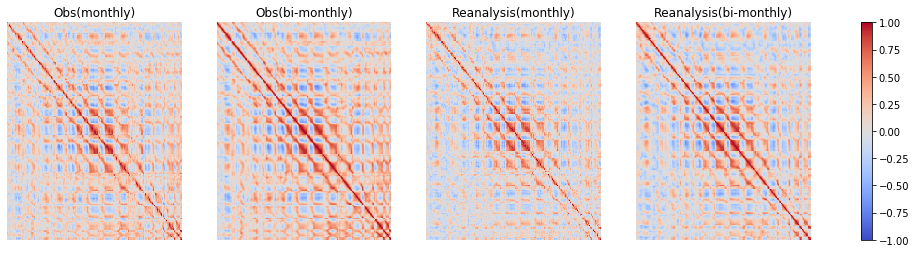

In [8]:
from coefficient_maps import plot_covariance

plot_covariance([S_obs_month, S_obs_season, S_rean_month, S_reanal_season], 
                ['Obs(monthly)', 'Obs(bi-monthly)', 'Reanalysis(monthly)', 'Reanalysis(bi-monthly)'])

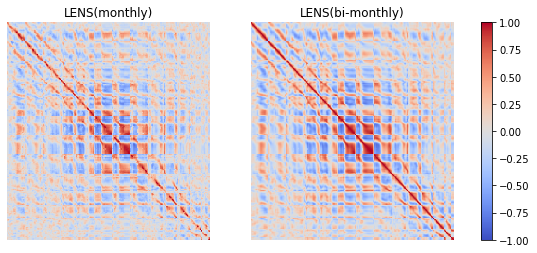

In [15]:
plot_covariance([S_obs_month_lens, S_obs_season_lens], 
                ['LENS(monthly)', 'LENS(bi-monthly)', 'Reanalysis(monthly)'])

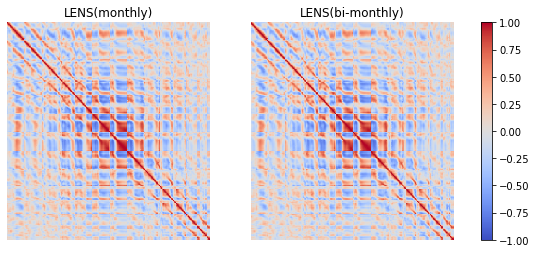

In [16]:
plot_covariance([S_reanal_month_lens, S_reanal_season_lens], 
                ['LENS(monthly)', 'LENS(bi-monthly)', 'Reanalysis(monthly)'])

In [91]:
yr_df = pd.DataFrame(np.arange(1940, 1990), columns=['Year'])
yr_df['alpha=.9'] = yr_df.Year.apply(lambda x: .9**(1990-x))
yr_df['alpha=.95'] = yr_df.Year.apply(lambda x: .95**(1990-x))
yr_df['alpha=.975'] = yr_df.Year.apply(lambda x: .975**(1990-x))
yr_df = yr_df.melt(id_vars=['Year'])
#yr_df.columns = ['Year', 'Alpha', 'Weight']

In [92]:
yr_df.head()

,Year,variable,value
0,1940,alpha=.9,0.005154
1,1941,alpha=.9,0.005726
2,1942,alpha=.9,0.006363
3,1943,alpha=.9,0.007070
4,1944,alpha=.9,0.007855


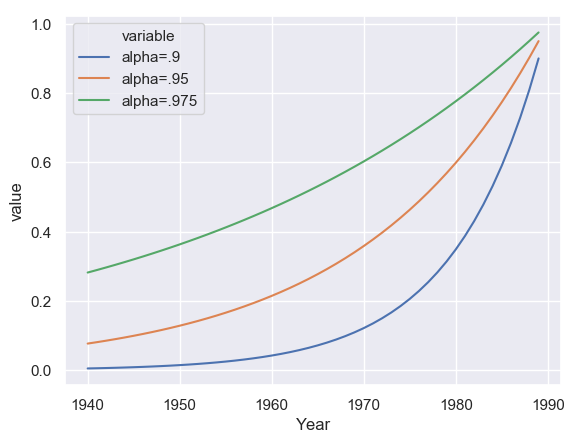

In [93]:
sns.set()
sns.lineplot(x='Year', y='value', hue='variable', data=yr_df)

In [105]:
t.head()

,Method,Region,MSE,R2,Coefs,alpha
0,NZI,avg,0.862066,0.237402,[-0.5312119423140121],0.975
1,Nino 3.4,avg,0.978762,0.134171,[0.36501287410613825],0.975
2,Nino 3.4 & NZI,avg,0.843870,0.253499,"[-0.4233558041048895, 0.14965906746565708]",0.975


# Regional (obs, .95, monthly)

In [110]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'monthly')
yavg, Y, regions = load_response(X.shape[0])
S = X.T@X/X.shape[0]
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .85)
D = edge_incidence(S, .85)
Dneigh = neighbors(fts)

alpha = .95

tele_df = pd.DataFrame()
regional_df = pd.DataFrame()

for i, y in enumerate(Y.T):
    print(regions[i])
    t = televaluation(Xnzi, Xenso, Xtele, y, regions[i], alpha, 50)
    tele_df = tele_df.append(t, ignore_index=True)
    
    d = full_weighted_cv(X, y, 
                 {'gtv_lens':Dlens,
                  'gtv_obs':D,
                 'fused':Dneigh}, 
                 lambda_gtv=np.linspace(0, 5, 10),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=5)
    d['region'] = regions[i]
    regional_df = regional_df.append(d, ignore_index=True)

Arizona(1)
Utah(1)
Arizona(2)
Utah(2)
Arizona(3)
Nevada(3)
Arizona(4)
California(4)
Nevada(4)
Utah(4)
Arizona(5)
California(5)
Arizona(6)
California(6)
Utah(6)
Arizona(7)
California(7)
Utah(7)


In [138]:
bestd = regional_df[regional_df.lambda_tv>0].sort_values(['region', 
                                 'test_mse']).drop_duplicates(['region', 
                                                               'method'])[['region', 'method', 'test_mse', 'test_r2']]

In [139]:
bestd.columns = ['Region', 'Method', 'MSE', 'R2']

In [140]:
bestd = bestd.append(tele_df[['Region', 'Method', 'MSE', 'R2']], ignore_index=True)

/Users/abbystevens/uchicago/tripods-climate/data+code/coefficient_maps.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Region'] = df.Region.apply(lambda x: shorten_region(x))
/Users/abbystevens/uchicago/tripods-climate/data+code/coefficient_maps.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sns.barplot(x='Region', y='R2', hue='Method', data=df)


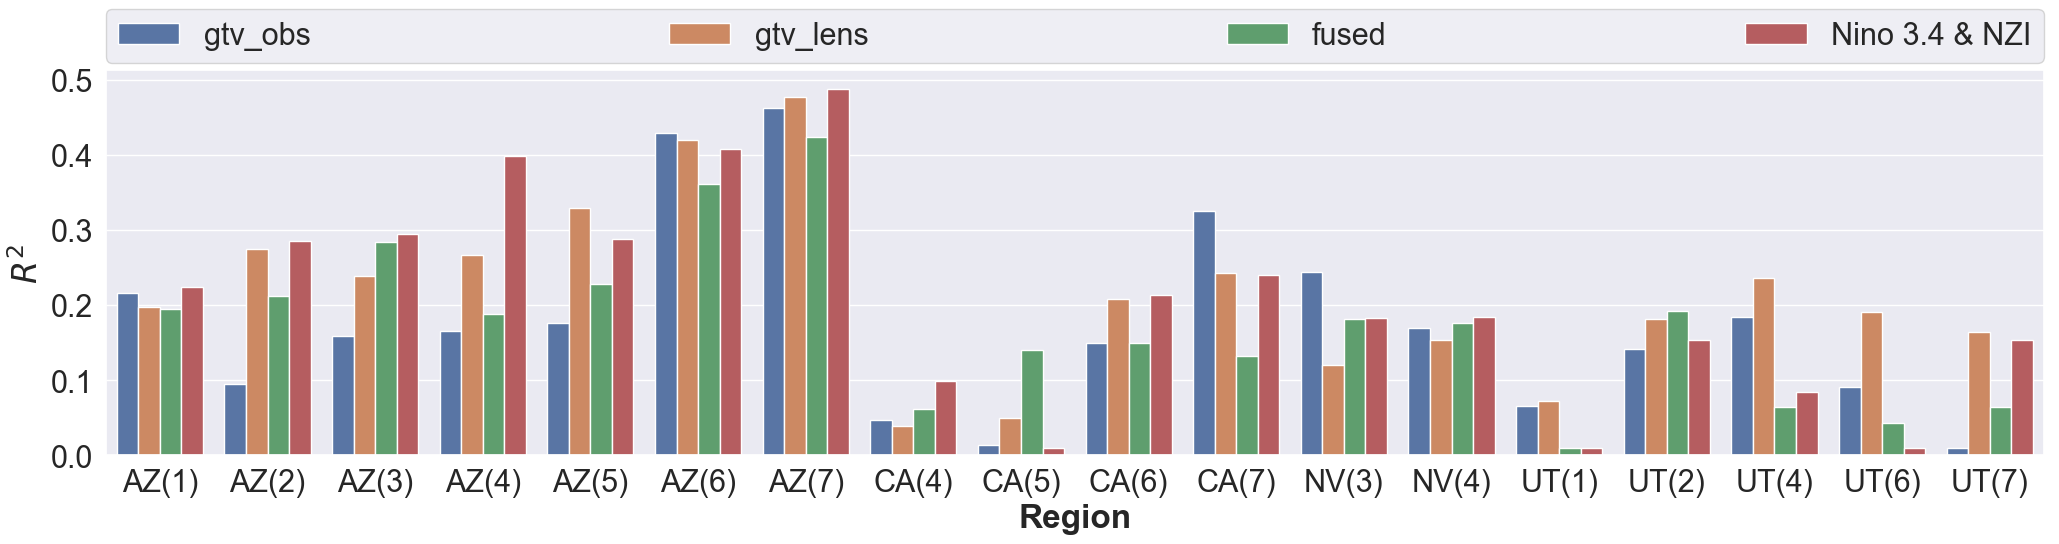

In [142]:
plot_regional_metrics(bestd[~bestd.Method.isin(['NZI', 'Nino 3.4'])], 'r2')

In [131]:
regional_df.sort_values(['region', 'test_mse']).drop_duplicates(['region', 'method'])

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2,region
281,gtv_obs,5.000000,0.12,0.220130,0.737095,1.003093,0.215406,Arizona(1)
31,gtv_lens,0.555556,0.12,0.221067,0.735976,1.025401,0.197958,Arizona(1)
50,fused,0.555556,0.01,0.023544,0.971881,1.029038,0.195113,Arizona(1)
692,gtv_lens,1.666667,0.23,0.404309,0.561113,0.817589,0.274268,Arizona(2)
651,fused,0.555556,0.12,0.282273,0.693586,0.887058,0.212603,Arizona(2)
611,gtv_obs,0.000000,0.12,0.273262,0.703368,0.994730,0.117028,Arizona(2)
1340,fused,2.222222,0.01,0.018536,0.978207,0.899674,0.284648,Arizona(3)
1292,gtv_lens,1.666667,0.23,0.384986,0.547369,0.956869,0.239171,Arizona(3)
1211,gtv_obs,0.000000,0.12,0.249821,0.706283,1.041110,0.172189,Arizona(3)
1892,gtv_lens,1.666667,0.23,0.420821,0.546278,0.823348,0.267132,Arizona(4)


In [222]:
X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'monthly', month=month)
yavg, Y, regions = load_response(X.shape[0])

S = X.T@X/X.shape[0]
Slens = Xlens.T@Xlens/Xlens.shape[0]
D = edge_incidence(S, .5)
Dlens = edge_incidence(Slens, .85)
Dneigh = neighbors(fts)

t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', .9, 50)
t['month'] = month
tele_df = tele_df.append(t, ignore_index=True)

d = full_weighted_cv(X, yavg, 
             {'gtv_lens':Dlens,
             'fused_lasso':Dneigh},
             lambda_gtv=np.linspace(0, 5, 10),
             #lambda_lasso=np.linspace(0.01, 1, 10),
                     lambda_lasso = [.1, .25],
             auto_cv=True, alpha=.9,
             t=50,k=10)



In [221]:
d.sort_values(['method', 'test_mse']).drop_duplicates(['method'])

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2
9,fused_lasso,0.444444,0.398909,0.603918,0.345532,0.979438,0.133573
0,gtv_lens,0.000000,0.717814,0.889067,0.036514,1.119936,0.009285


july
aug


/Users/abbystevens/uchicago/tripods-climate/data+code/gtv.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  XD, bigY, invD = augmented_system_lasso(X, y, D, l1/l3, 0, l1_only=True)
/Users/abbystevens/uchicago/tripods-climate/data+code/gtv.py:41: RuntimeWarning: invalid value encountered in multiply
  bigD = np.vstack([lam1*D, np.identity(p)])
/usr/local/lib/python3.6/site-packages/numpy/lib/scimath.py:274: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
/usr/local/lib/python3.6/site-packages/glmnet_python/elnet.py:191: RuntimeWarning: invalid value encountered in double_scalars
  alm[0] = scipy.exp(2*t1 - t2)


IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 100

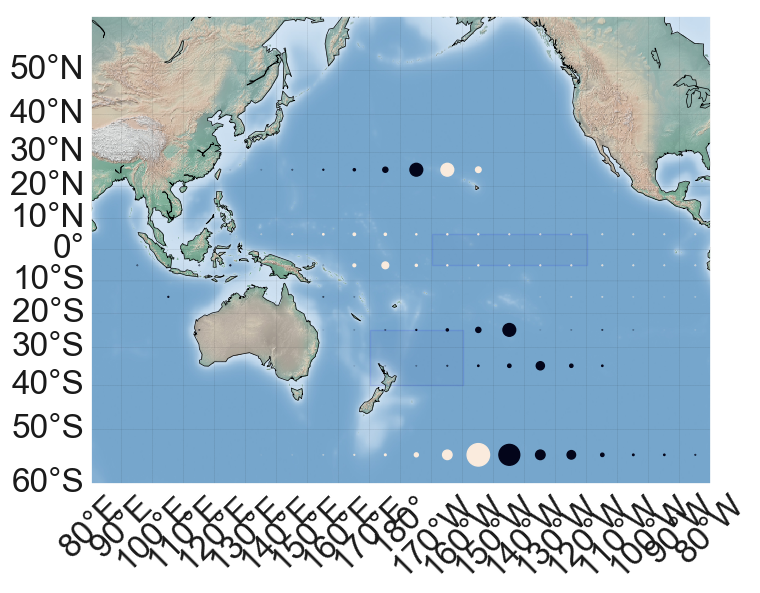

In [290]:
tele_df = pd.DataFrame()
monthly_df = pd.DataFrame() 
alpha = .95
las = linear_model.LassoCV()
lm = linear_model.LinearRegression()
for month in ['july', 'aug', 'sept', 'oct']:
    print(month)
    X, Xlens, fts, Xnzi, Xenso, Xtele = load_predictors('obs', 'one_month', month=month)
    yavg, Y, regions = load_response(X.shape[0])
    
    S = X.T@X/X.shape[0]
    Slens = Xlens.T@Xlens/Xlens.shape[0]
    D = edge_incidence(S, .75)
    Dlens = edge_incidence(Slens, .75)
    Dneigh = neighbors(fts)
    
    #t = televaluation(Xnzi, Xenso, Xtele, yavg, 'avg', alpha, 50)
    #t['month'] = month
    #tele_df = tele_df.append(t, ignore_index=True)

    d = full_weighted_cv(X, yavg, 
                 {'gtv_lens':Dlens},
                 lambda_gtv=np.linspace(0, 1, 20),
                 lambda_lasso=np.linspace(0.01, 1, 10),
                 auto_cv=False, alpha=alpha,
                 t=50,k=10)
    d['month'] = month
    l1,ltv=d.sort_values('test_mse').iloc[0][['lambda_1', 'lambda_tv']].values
    beta = weighted_gtv2(X[:50], yavg[:50], Dlens, l1, ltv)
    fts['coef'] = beta
    plot_coefs(fts)
    monthly_df = monthly_df.append(d)

In [292]:
ltv


0.0

In [287]:
a,b=d.sort_values('test_mse').iloc[0][['lambda_1', 'lambda_tv']].values

0.05263157894736842

In [271]:
monthly_df.sort_values(['month', 'method', 'test_mse']).drop_duplicates(['month', 'method'])

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2,month
1,gtv_lens,0.000000,0.12,0.391152,0.576106,0.797247,0.294742,aug
82,gtv_lens,0.421053,0.23,0.522120,0.434176,0.873564,0.227230,july
12,gtv_lens,0.052632,0.23,0.451716,0.510473,0.941751,0.166911,oct
21,gtv_lens,0.105263,0.12,0.354141,0.616216,0.905444,0.199029,sept


In [266]:
tele_df.pivot('Method', 'month', 'R2')[['july', 'aug', 'sept', 'oct']]

month,july,aug,sept,oct
Method,,,,
NZI,0.129163,0.162275,0.293504,0.312232
Nino 3.4,0.130665,0.119975,0.111013,0.118338
Nino 3.4 & NZI,0.173669,0.186589,0.296317,0.314542


,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2,month
93,gtv_lens,5.000000,0.34,0.657737,0.287208,0.941718,0.166941,aug
92,gtv_lens,5.000000,0.23,0.559101,0.394100,0.912806,0.192516,july
24,gtv_lens,1.111111,0.45,0.696189,0.245537,0.991317,0.123065,oct
21,gtv_lens,1.111111,0.12,0.477312,0.482735,0.918096,0.187837,sept


In [215]:
monthly_df.sort_values(['month', 'method', 'test_mse']).drop_duplicates(['month', 'method'])

,method,lambda_tv,lambda_1,train_mse,train_r2,test_mse,test_r2,month
9,fused_lasso,0.444444,0.154785,0.360171,0.609681,0.853094,0.245338,aug
12,gtv_lens,0.666667,0.082518,0.252796,0.726043,0.839726,0.257164,aug
1,fused_lasso,0.000000,0.534742,0.923344,-0.000632,1.132166,-0.001533,july
12,gtv_lens,0.666667,0.213762,0.405409,0.560657,1.076657,0.047571,july
1,fused_lasso,0.000000,0.275194,0.546191,0.408091,0.977044,0.135690,oct
0,gtv_lens,0.000000,0.275194,0.546191,0.408091,0.977044,0.135690,oct
9,fused_lasso,0.444444,0.416652,0.667088,0.277074,0.965737,0.145693,sept
10,gtv_lens,0.555556,0.281533,0.550271,0.403669,0.977210,0.135543,sept


In [213]:
Dneigh.shape

(785, 225)

In [190]:
XD, bigY, invD = augmented_system_lasso(X[:50], yavg[:50], D, 1, 0, l1_only=True)
n = 50
fit = cvglmnet(x = XD, y = bigY, family = 'gaussian', ptype = 'mse', nfolds = 5,
                    weights = np.array([alpha**(n-t) for t in np.arange(1,n+1)]))

{'class': 'cvglmnet',
 'cvlo': array([0.94569926, 0.97000933, 0.99263502, 1.01973929, 1.04828467,
        1.07928015, 1.11312988, 1.13928994, 1.16550425, 1.18205168,
        1.19130438, 1.20385247, 1.21460224, 1.23027312, 1.24767143,
        1.26166296, 1.26791381, 1.27106102, 1.27309717, 1.27760714,
        1.28294561, 1.28052184, 1.2743653 , 1.27266444, 1.27351115,
        1.26459501, 1.25511912, 1.25402987, 1.26241384, 1.28174178,
        1.29477589, 1.30956029, 1.33589159, 1.35711744, 1.37666322,
        1.3990936 , 1.44207096, 1.48247943, 1.51400981, 1.54685063,
        1.5729202 , 1.59329296, 1.61967671, 1.64852406, 1.67396112,
        1.6974394 , 1.72008238, 1.73694711, 1.75630363, 1.7787321 ,
        1.79979016, 1.81277171, 1.82361158, 1.82768675, 1.82629192,
        1.8233879 , 1.82155252, 1.82670828, 1.83546719, 1.8541184 ,
        1.84106095, 1.8276714 , 1.82661527, 1.84324035, 1.86235352,
        1.88246402, 1.88534476, 1.88388953, 1.88284797, 1.87865483,
        1.88277492

In [183]:
type(nobs)
nfolds = 5

In [184]:
ma = scipy.tile(scipy.arange(nfolds), [1, scipy.floor(nobs/nfolds)])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [185]:
scipy.arange(nfolds)

array([0, 1, 2, 3, 4])

In [186]:
[1, scipy.floor(nobs/nfolds)]

[1, 15.0]

In [188]:
scipy.tile(scipy.arange(nfolds), [1, int(scipy.floor(nobs/nfolds))])

array([[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
        4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0,
        1, 2, 3, 4, 0, 1, 2, 3, 4]])

In [45]:
def augmented_system_lasso(X,y,D,lam1,lam2, l1_only=False):
    [n,p] = X.shape
    [m,p] = D.shape
    if l1_only:
        bigX = X
        bigY = y
    else:
        bigX = np.vstack([X, np.sqrt(n*lam2)*D])
        bigY = np.append(y, np.zeros(m))
    bigD = np.vstack([lam1*D, np.identity(p)])
    invD = np.linalg.solve(bigD.T @ bigD, bigD.T)
    XD = bigX @ invD
    return XD, bigY, invD

In [47]:
XD, bigY, invD = augmented_system_lasso(X, yavg, D, 1, 1)

In [54]:
np.where(invD!=0) 

(array([  0,   1,   1, ..., 899, 899, 899]),
 array([4470,    0,    1, ..., 5367, 5368, 5369]))

In [55]:
XD.shape

(4549, 5370)

In [56]:
bigY.shape

(4549,)

NameError: name 'weights' is not defined